<a href="https://colab.research.google.com/github/NatasaKinzy/Data-Science/blob/main/Unit4/NataKinzU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import library
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import graphviz as gv
import pymc as pm

# Unit 4 Project

**Is a Hierarchical or Nonhierarchical model better at modeling Total Rebounds vs player position in basketball?**



# Context



In basketball, rebounds are when a player gains control of a ball after a missed shot. The ball bounces off, or rebounds, off the backboard. A higher score is good because it allows the team of the player who caught the ball to gain control over it and maybe even get a second chance at the shot. My project will model total rebounds of many basketball players. The priors will be player positions which should help predict which position will have the most total rebounds. I'll show a hierarchical and nonhierarchical likelihood for this dataset.

In [3]:
#importing dataset and a few other things for models
url_bb = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv'

In [4]:
bb_data = ['Pos', 'TRB']

In [5]:
bb_data = pd.read_csv(url_bb)

In [6]:
pos_encode = pd.Categorical(bb_data['Pos'])

In [7]:
pos_idx = pos_encode.codes

In [8]:
pos_coords = {"pos": pos_encode.categories}

# Plot Data

<Axes: ylabel='TRB'>

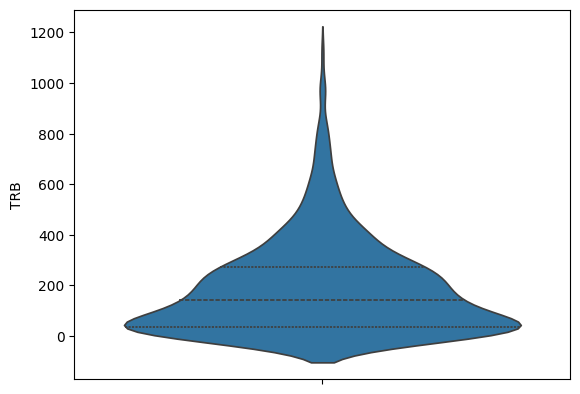

In [9]:
sns.violinplot(bb_data['TRB'],inner='quart')

In [ ]:
 y = pm.HalfNormal('y',
                  mu = μ[pos_idx],
                  sigma = σ[pos_idx],
                  observed=bb_data['TRB'])

# Nonhierarchical

In [ ]:
with pm.Model(coords=pos_coords) as bb_nh_model:
    #priors
    #dims="pos" means to apply the prior seperately to each position
    μ = pm.Normal('μ', mu=200, sigma=35,
                  dims="pos")
    #mu is mean which should be around 200
    #sigma is spread, medium for medium curvature
    σ = pm.HalfNormal('σ', sigma=35,
                      dims="pos")

    #The idx variable tells my model which diffs belong to the same position
    #this will get my model to generate a posterior for each position
    y = pm.HalfNormal('y',
                  sigma = σ[pos_idx],
                  observed=bb_data['TRB']) #Use only 'TRB' colum

    #bb for basketball, nh for nonheirarchical
    idata_bb_nh = pm.sample()

In [ ]:
#Posterior Predictive
pm.sample_posterior_predictive(idata_bb_nh, model=bb_nh_model, extend_inferencedata=True)
az.plot_ppc(idata_bb_nh, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(75, 1000)

# Hierarchical

In [ ]:
with pm.Model(coords=pos_coords) as bb_h_model: # Use pos_coords
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all positions
    μ_mu = pm.StudentT('μ_mu', nu = 30, mu = 200, sigma = 10)
    #mu should be mean of prior, nu controls shape of posterior predictive
    #which I want to look closer to a normal distribution so it's large
    #smaller sigma makes narrower/taller distribution
    μ_sd = pm.HalfStudentT('μ_sd', nu = 30, sigma = 10)
    μ_nu = pm.Exponential('μ_nu', lam = 1/30)

    # priors. There is a different prior for each position,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.StudentT('μ', nu = μ_nu,
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "pos") # Use "pos" instead of "aa"

    σ = pm.HalfStudentT('σ', nu = 30, sigma = 10, dims = "pos")

    v = pm.Exponential('v', lam = 1/30, dims = "pos")

    #likelihood; same as before
    y = pm.StudentT('y', nu = v[pos_idx], #I include the prior in my likelihood
                  mu = μ[pos_idx], #I include the prior in my likelihood
                  sigma = σ[pos_idx], #I include the prior in my likelihood
                  observed = bb_data['TRB'])

    #bb for basketball, h for heirarchical
    idata_bb_h = pm.sample()

In [ ]:
with bb_h_model:
    pm.sample_posterior_predictive(idata_bb_h, extend_inferencedata=True)

fig, ax = plt.subplots(figsize=(8,6))
az.plot_ppc(idata_bb_h, num_pp_samples = 100, ax=ax, colors = ["C1", "C0", "C3"])
ax.set_xlim(75, 1000)
plt.show()

# Nonhierarchical vs Hierarchical

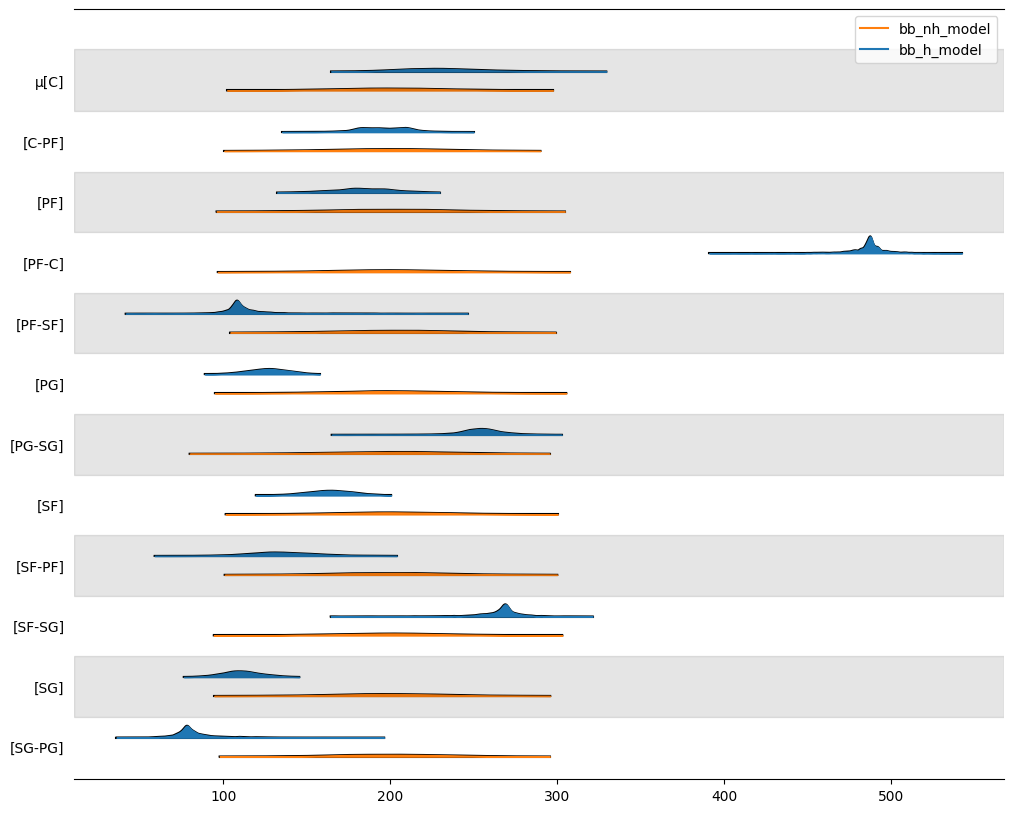

In [104]:
axes = az.plot_forest([idata_bb_h, idata_bb_nh], kind="ridgeplot",
                      model_names=['bb_h_model', 'bb_nh_model'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

# Which was better?

The hierarchical model takes substantially longer to run, however, it does seem to model the data much better. The nonhierarchical model models the mean of the data much better but the hierarchical model shows the variance in the data and overall indicates the mean. The posterior of the hierarchical model fits much closer to the observed data than the posterior of the nonheirarchical as well. That may have been due to the fact that the nonhierarchical was HalfNormal distribution and the hierarchical was a StudentT distribution, so maybe it's not as fair of a comparison. The hierarchical model does take SUBSTANTIALLY more time than the nonhierarchical model though which was extremely frustrating when trying to edit my model.

Also, the ridge plot feels like a lie because it makes it look like the nonhierarchical model is so uniform and consistent and accurate, but the hierarchical model fits the observed data much better. Although that could be due to the fact that the hierarchical model shows more variance and the data itself is pretty varried.